# Treinando Pong game utilizando Aprendizado por Reforço

O objetivo deste tutorial é aprender o básico e o necessário da área de Aprendizado por Reforço. Vamos nos basear em um dos maiores clássicos da história dos video-games: **O jogo Pong**.

![Pong](https://media2.giphy.com/media/aTGwuEFyg6d8c/giphy.gif)

In [13]:
!pip install pygame

In [14]:
import os
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"

import pygame
pygame.init()

(4, 2)

In [15]:
import sys
import numpy as np
import gym
from gym.utils import seeding



In [16]:
class Bar:
    def __init__(self, x, y, screen_width, screen_height,
                 length=20, width=2, velocity=2, horizontal=True, np_random=np.random):
        self.np_random = np_random
        self.x = int(x)
        self.y = int(y)
        self.length = length
        self.width = width
        self.velocity = velocity
        self.horizontal = horizontal
        self.screen_width = screen_width
        self.screen_height = screen_height
        self._direction = 0

    def draw(self, screen, color=(255, 255, 255)):  # desenhar em pygame
        pygame.draw.rect(screen, color, (
                         self.x-self.width/2, self.y-self.length/2, self.width, self.length))

    # mode = machine | enemy
    # arg  = action  | ball
    def move(self, arg,  mode='human'):
        if mode == 'machine':
            actions = {
                0: lambda x: x,
                1: lambda x: x + self.velocity,
                2: lambda x: x - self.velocity,
            }
            self.y = actions[arg](self.y)

        elif mode == 'enemy':
            ball = arg
            # Depois de começar a se movimentar, o inimigo demora um tempo
            # para verificar novamente a posição da bola
            if self._direction != 0:
                if self.np_random.random() < .08:
                    self._direction = 0
            # O inimigo só consegue "ver" a bola quando ela está próxima,
            # e tem um tempo de resposta aleatório
            elif ball.x >= self.screen_width*.6 and self.np_random.random() < .85:
                self._direction = np.sign(ball.y - self.y)
            self.y += self.velocity*self._direction

        else:
            raise ValueError(f'Invalid mode: {mode}')

        self.y = np.clip(self.y, 0, self.screen_height)

In [17]:
class Ball:
    def __init__(self, x, y, size, velocity=1, np_random=np.random):
        self.np_random = np_random
        self.x = int(x)
        self.y = int(y)
        self.size = size
        self.abs_velocity = velocity
        self.reset_velocity()

    def reset_velocity(self):
        v = self.abs_velocity
        direction = self.np_random.uniform(np.pi/8, np.pi/3)  # first quadrant
        direction *= self.np_random.choice([-1, 1])  # right side
        direction += self.np_random.choice([0, np.pi])  # left side
        self.velocity = [
            v*np.cos(direction), -v*np.sin(direction)]

    def move(self):
        self.x += self.velocity[0]
        self.y += self.velocity[1]

    def draw(self, screen, color=(255, 255, 255)):
        pygame.draw.rect(screen, color, (
            self.x - self.size, self.y - self.size, 2*self.size, 2*self.size))

    def bounce(self, wall):
        lookup_table = {False: [-1, 1],
                        True: [1, -1]}
        if abs(self.x - wall.x) < (wall.width/2 + self.size - 1) \
                and abs(self.y - wall.y) < (wall.length/2 + self.size):
            self.velocity[0] *= lookup_table[wall.horizontal][0]
            self.velocity[1] *= lookup_table[wall.horizontal][1]
            return True
        return False

In [18]:
class PongEnv(gym.Env):
    _gym_disable_underscore_compat = True
    metadata = {'render.modes': ['human', 'rgb_array']}
    reward_range = (-float('inf'), float('inf'))
    action_space = gym.spaces.Discrete(3)
    observation_space = gym.spaces.Box(
        low=-np.float32('inf'), high=np.float32('inf'), shape=(4,))

    def __init__(self, height=300, width=400, repeat_actions=3,
                 bar_velocity=3, ball_velocity=2,
                 num_matches=7, fps=50):

        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0, 0, 0]),
            high=np.array([width, height, width, height]),
            dtype=np.float32)

        self.height = height
        self.width = width
        self.num_matches = num_matches
        self.fps = fps
        self.clock = pygame.time.Clock()
        self.repeat_actions = repeat_actions

        param_names = ['x', 'y', 'length', 'width', 'velocity', 'horizontal']
        w, h, vel = width, height, bar_velocity
        bar_parameters = [
            # (x,    y,   len, width, vel, horizontal)
            (w/27,   h/2, h/3, w/50, vel, False),  # jogador
            (w-w/27, h/2, h/3, w/50, vel, False),  # oponente
            (w/2,    0,   5,   w,    0,   True),   # teto
            (w/2,    h,   5,   w,    0,   True),   # chão
            (0,      h/2, h,   5,    0,   False),  # parede esq.
            (w,      h/2, h,   5,    0,   False),  # parede dir.
        ]
        # Obs: as paredes esquerda e direita têm propósito puramente estético

        self.bars = []
        for bar in bar_parameters:
            kwargs = dict(zip(param_names, bar))
            self.bars.append(
                Bar(screen_width=width, screen_height=height, **kwargs))

        self.control_bar = self.bars[0]
        self.other_bar = self.bars[1]
        self.left_wall = self.bars[4]
        self.right_wall = self.bars[5]

        self.ball = Ball(x=width/2, y=height/2, size=10,
                         velocity=ball_velocity)

        self.seed()
        self.viewer = None
        self.screen = None

    def reset_match(self):
        self.ball.x, self.ball.y = self.width/2, self.height/2
        self.control_bar.y = self.height/2
        self.other_bar.y = self.height/2
        self.ball.reset_velocity()

    def _get_state(self):
        return np.array([self.control_bar.x, self.control_bar.y,
                         self.ball.x, self.ball.y])

    def reset(self):
        self.reset_match()
        self.done = False
        self.score = [0, 0]
        return self._get_state()

    def step(self, action):
        reward = 0
        for _ in range(self.repeat_actions):
            reward += self._step(action)
            if self.done:
                break
        return self._get_state(), reward, self.done, {}

    def _step(self, action):
        if self.done:
            return 0

        self.control_bar.move(action, mode='machine')
        self.other_bar.move(self.ball, mode='enemy')
        self.ball.move()

        for bar in self.bars:
            self.ball.bounce(bar)

        if self.ball.bounce(self.left_wall):
            player_scored = False
            self.score[1] += 1
        elif self.ball.bounce(self.right_wall):
            player_scored = True
            self.score[0] += 1
        else:  # no points
            return 0

        reward = 500
        if max(self.score) > self.num_matches / 2:
            self.done = True
            reward += 2000
        self.reset_match()
        return reward if player_scored else -reward

    def draw(self):
        if self.screen is None:
            self.screen = pygame.Surface((self.width, self.height))
        self.screen.fill((20, 20, 20))
        for bar in self.bars:
            bar.draw(self.screen)
        self.ball.draw(self.screen)

    def render(self, mode='human', wait=True):
        if wait:
            self.clock.tick(self.fps)

        self.draw()
        img = pygame.surfarray.array3d(self.screen).astype(np.uint8)

        # Conversão de eixos [y][x][canal] para [x][y][canal]
        img = np.transpose(img, [1, 0, 2])

        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            if self.viewer is None:
                from gym.envs.classic_control import rendering
                self.viewer = rendering.SimpleImageViewer(maxwidth=self.width)
            self.viewer.imshow(img)
            self.viewer.window.set_caption(
                f'Pong - {self.score[0]} x {self.score[1]} ({sys.argv[0]})')
        else:
            return super().render(mode=mode)

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        self.ball.np_random = self.np_random
        for bar in self.bars:
            bar.np_random = self.np_random
        return [seed]

In [19]:
class EasyPongEnv(PongEnv):
    observation_space = gym.spaces.Box(
        low=-np.float32('inf'), high=np.float32('inf'), shape=(2,))

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        low = self.observation_space.low
        high = self.observation_space.high
        self.observation_space = gym.spaces.Box(
            low=np.array([low[0] - high[2], low[1] - high[3]]),
            high=np.array([high[0] - low[2], high[1] - low[3]]),
            dtype=np.float32)

    def _get_state(self):
        dx = self.control_bar.x - self.ball.x  # s[0] - s[2]
        dy = self.control_bar.y - self.ball.y  # s[1] - s[3]
        return np.array([dx, dy])

In [29]:
from gym.envs.registration import register


register(
    id='pong-normal-v3',
    entry_point='PongEnv',
    max_episode_steps=7_500,
)

register(
    id='pong-easy-v3',
    entry_point='EasyPongEnv',
    max_episode_steps=7_500,
)

## 🏓 Sobre o Pong

Começaremos falando sobre o problema, ou seja, sobre o jogo Pong. Este que foi o primeiro jogo de video-game lucrativo da história, publicado em 1972, constando 48 anos de legado.

Pong simula uma partida de tênis, existem duas "raquetes" e uma bola, e o objetivo de cada uma das raquetes é não somente evitar que a bola passe por ela, como também fazer com que esta passe pela linha que a outra raquete protege, criando assim a premissa que sustenta o interesse pelo jogo. Queremos então desenvolver um algoritmo capaz de &mdash; sem nenhuma explicação adicional &mdash; maximizar as suas recompensas, sendo as ações, os estados e as recompensas, todas relativas ao jogo Pong. Teremos no final, portanto, um modelo treinado capaz de bom desempenho dentro do ambiente. 

## 💻 Programando...

### Importando o Gym

O **[Gym](https://gym.openai.com/)** é uma biblioteca desenvolvida pela OpenAI que contém várias implementações prontas de ambientes de Aprendizagem por Reforço. Ela é muito utilizada quando se quer testar um algoritmo de agente sem ter o trabalho de programar seu próprio ambiente.

<img src="https://user-images.githubusercontent.com/10624937/42135602-b0335606-7d12-11e8-8689-dd1cf9fa11a9.gif" alt="Exemplos de Ambientes do Gym" class="inline"/>
<figcaption>Exemplo de Ambientes do Gym</figcaption>
<br>

Para se ter acesso a esses ambientes, basta importar o Gym da seguinte forma:

In [ ]:
import gym

### O que é um Ambiente?

Um **Ambiente** de Aprendizagem por Reforço é um espaço que representa o nosso problema, é o objeto com o qual o nosso agente deve interagir para cumprir sua função. Isso significa que o agente toma **ações** nesse ambiente, e recebe **recompensas** dele com base na qualidade de sua tomada de decisões.

Todos os ambientes são dotados de um **espaço de observações**, que é a forma pela qual o agente recebe informações e deve se basear para a tomada de decisões, e um **espaço de ações**, que especifica as ações possíveis do agente. No xadrez, por exemplo, o espaço de observações seria o conjunto de todas as configurações diferentes do tabuleiro, e o espaço de ações seria o conjunto de todos os movimentos permitidos.

<img src="https://www.raspberrypi.org/wp-content/uploads/2016/08/giphy-1-1.gif" alt="Uma Ação do Xadrez" class="inline"/>

### Como Funciona um Ambiente do Gym?

Agora que você já sabe o que é um ambiente, é preciso entender como nosso agente interage efetivamente com ele. Todos os ambientes do Gym possuem alguns métodos simples para facilitar a comunicação com eles:

<br>

| Método         | Funcionalidade                                        |
| :------------- |:----------------------------------------------------- |
| `reset()`      | Inicializa o ambiente e recebe a observação inicial   |
| `step(acao)`   | Executa uma ação e recebe a observação e a recompensa |
| `render()`     | Renderiza o ambiente                                  |
| `close()`      | Fecha o ambiente                                      |

<br>

Assim, o código para interagir com o ambiente costuma seguir o seguinte modelo:

---

```python
env = gym.make("Nome do Ambiente")                   # Cria o ambiente
estado = env.reset()                                 # Inicializa o ambiente
done = False                                         # Variável que diz se acabou

while not done:
    env.render()                                     # Renderiza o ambiente
    acao = random()                                  # Define alguma ação
    estado, recompensa, done, info = env.step(acao)  # Executa uma ação
    
env.close()                                          # Fecha o ambiente
```

---

### Criando um Ambiente

Para utilizar um dos ambientes do Gym, nós usamos a função ```gym.make()```, passando o nome do ambiente desejado como parâmetro e guardando o valor retornado em uma variável que chamaramos de ```env```. A lista com todos os ambientes do gym pode ser encontrada [aqui](https://gym.openai.com/envs/#classic_control). Nesse workshop, utilizaremos um ambiente de pong do Grupo Turing, que requer a instalação do [Turing Envs](https://github.com/GrupoTuring/turing-envs).

In [31]:
env = gym.make("Pong-v0")
env.seed(0)

[0, 592379725]


#### Características do Pong

Antes de treinar qualquer agente, primeiro é preciso entender melhor quais as características do nosso ambiente.

O **Espaço de Observação** do pong (modo fácil) é definido por 2 informações:

| Estado    | Informação                            |
| :-------- | :------------------------------------ |
| 0         | Distância _x_ entre a bola e o agente |
| 1         | Distância _y_ entre a bola e o agente |

Dessa forma, a cada instante recebemos uma lista da observação com o seguinte formato:

In [32]:
print(env.observation_space.sample())

[[[142 215 172]
  [162 241  86]
  [190 155 236]
  ...
  [ 60 169 230]
  [193 100  36]
  [ 65 129  65]]

 [[237 135  15]
  [230  50 240]
  [ 28 105  91]
  ...
  [190  77 123]
  [105  98  54]
  [147 212  99]]

 [[201 120 217]
  [  6 229 169]
  [212 105  53]
  ...
  [  1 115 166]
  [ 81   2 184]
  [ 33 208 237]]

 ...

 [[211 188  15]
  [ 12  48 253]
  [166  30 237]
  ...
  [218 220 189]
  [144  86 109]
  [236  76 212]]

 [[200  51 169]
  [249 116 138]
  [128  93 132]
  ...
  [112 112  41]
  [ 22 221 118]
  [114  68 198]]

 [[218  51 198]
  [205 254 207]
  [ 44 246 253]
  ...
  [113  39 239]
  [ 83 225  84]
  [ 92  92  39]]]


Já o **Espaço de Ação** é composto por três ações: mover o jogador para cima, baixo, ou deixá-lo parado:

| Ação | Significado      |
| :--- | :--------------- |
| 0    | Ficar parado     |
| 1    | Mover para baixo |
| 2    | Mover para cima  |

Por exemplo, para mover a barra para a cima, fazemos `env.step(2)`.

In [33]:
print(env.action_space.sample())

5


Por fim, cada vez que tomamos uma ação, recebemos do ambiente uma **recompensa**, conforme a tabela abaixo:

| Ocorrência          | Recompensa |
| :------------------ | ---------: |
| Ponto do Agente     | $+500$     |
| Ponto do Oponente   | $-500$     |
| Vitória do Agente   | $+2000$    |
| Vitória do Oponente | $-2000$    |

O primeiro jogador a fazer quatro pontos ganha o jogo. Além disso, as recompensas são cumulativas. Isso significa que se o oponente fizer um ponto _e_ ganhar o jogo, a recompensa é de $-2500$.

### ✍ Gym na prática

Agora que entendemos como o Gym funciona, vamos tentar aplicar esse conhecimento criando uma função que roda um episódio de Pong tomando ações aleatórias!

OBS: Lembrete das funções do Gym

| Método                 | Funcionalidade                                          |
| :--------------------- |:------------------------------------------------------- |
| `reset()`              | Inicializa o ambiente e recebe a observação inicial     |
| `step(acao)`           | Executa uma ação e recebe a observação e a recompensa   |
| `render()`             | Renderiza o ambiente                                    |
| `close()`              | Fecha o ambiente                                        |

In [36]:
!apt-get install python-opengl -y

!apt install xvfb -y

!pip install pyvirtualdisplay

!pip install piglet

from pyvirtualdisplay import Display
Display().start()
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
# Essa função deve rodar um episodio de Pong escolhendo ações aleatórias
def rodar_ambiente():
    # Criando o ambiente 'turing_envs:pong-easy-v0'
    env = gym.make("Pong-v0")

    # Resete o ambiente e receba o primeiro estado
    estado = env.reset()
    img = plt.imshow(env.render('rgb_array'))
    # Inicializando done como false
    done = False

    # Loop de treino
    while not done:
        # Escolha uma acao aleatoria
        acao = env.action_space.sample()

        # Tome essa acao e receba as informacoes do estado seguinte
        prox_estado, recompensa, done, info = env.step(acao)

        # Renderize o ambiente
        img.set_data(env.render('rgb_array'))
        #env.render()
        display.display(plt.gcf())
        display.clear_output(wait=True)
        # Atualizando o estado
        estado = prox_estado

    # Fechando o ambiente
    env.close()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (462 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The 

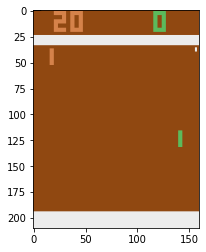

In [37]:
# Testando a função
rodar_ambiente()

## 👩‍💻 Algoritmo

Primeiramente, precisaremos utilizar uma biblioteca chamada ***NumPy*** para auxiliar nas computações. Esta é uma biblioteca do Python capaz de manusear diversas computações matemáticas com maestria e será importante futuramente para o nosso trabalho.

In [38]:
import numpy as np # Importando a biblioteca NumPy
import gym         # Importando a Biblioteca Gym

# Criando o nosso Ambiente: Pong
env = gym.make("Pong-v0")

# Número total de ações: 3
# 0 = parado; 1 = baixo; 2 = cima
n_acoes = env.action_space.n

print('Número de ações:', n_acoes)

Número de ações: 6


### 🔢 Discretizando o nosso Estado

Como comentamos anteriormente, o estado que o nosso agente recebe consiste das distâncias horizontal e vertical da raquete controlada até a bola. Dessa forma, se a nossa tela possuir 800 unidades de largura e 600 unidades de altura, a quantidade total de diferentes estados possíveis seria aproximadamente $3 \times 800 \times 600 = 960000$.

Como Q-Learning é um algoritmo que guarda em uma tabela as estimativas do Q de cada ação para cada estado, esse gigantesco número de estados exigiria não somente guardar como atualizar cada um desses Q. Não é uma situação ideal.

Para simplificar (e agilizar) a situação, "discretizar" os nossos estados é razoável e esperado. Faremos com que estados similares o suficiente sejam considerados como iguais e comparilhem das mesmas estimativas, já que não faz sentido distinguir o estado (502,234) do estado (515,222).

In [44]:
def discretiza_estado(estado):
    return tuple(np.round(x/10) for x in estado)

### 🔀 Escolhendo Ações

Para o processo de de escolha de ação, é necessário lembrar do dilema entre **Exploração** e **Explotação**. Nosso modelo precisa estabelecer um equilíbrio entre **explorar o ambiente**, escolhendo ações que ele não costuma tomar para encontrar alguma solução que ele não havia pensado antes, e **aproveitar** o conhecimento que já possui, tomando ações que ele acredita serem as melhores para maximizar as recompensas que receberá no episódio.

De forma a assegurar que o agente busque tanto novas alternativas que podem gerar melhores resultados quanto seja capaz de utilizar o aprendizado obtido de forma a maximizar seu retorno, existem diversas estratégias para a escolha de exploração e explotação. Uma das mais utilizadas, que também vamos utilizar aqui, é a seleção de ações pela estratégia do **"$\epsilon$-greedy"**.

#### A Estratégia **$\epsilon$-greedy**

O algoritmo "$\epsilon$-greedy" é definido da seguinte forma: é retirado um número aleatório, no intervalo entre 0 e 1. caso este número tenha valor inferior ao valor do epsilon, a escolha será de uma ação aleatória, o que configura exploração. Caso este número seja superior ao epsilon, a ação a ser tomada é a que gera a maior recompensa de acordo com os valores da tabela Q.

Este valor de $\epsilon$ não é constante ao longo do treinamento. Inicialmente, este valor é alto, incentivando a maior exploração do ambiente. A medida que o treinamento ocorre, mais informação sobre o ambiente é adquirida, conseguindo uma tabela Q mais representativa da realidade. Dessa forma, quanto mais avançado no treinamento, menor a necessidade de exploração e maior a necessidade de exploitar o conhecimento adquirido para maximizar a recompensa. Esta atualização do $\epsilon$ é chamada **"$\epsilon$-decay"** (decaimento do epsilon). Também é estabelecido um valor mínimo para o $\epsilon$, para que o agente nunca pare completamente de explorar o ambiente.

In [40]:
# Constantes da Política Epsilon Greedy
# Epsilon: probabilidade de experimentar uma ação aleatória
EPSILON = 0.7        # Valor inicial do epsilon
EPSILON_MIN = 0.01   # Valor mínimo de epsilon
DECAIMENTO = 0.98    # Fator de decaímento do epsilon (por episódio)

In [46]:
def escolhe_acao(env, Q, estado, epsilon):
    # Se não conhecermos ainda o estado, inicializamos o Q de cada ação como 0
    if estado not in Q.keys(): Q[estado] = [0] * n_acoes

    # Escolhemos um número aleatório com "np.random.random()"
    # Se esse número for menor que epsilon, tomamos uma ação aleatória
    if np.random.random() < epsilon:
        # Escolhemos uma ação aleatória, com env.action_space.sample()
        acao = env.action_space.sample()
    else:
        # Escolhemos a melhor ação para o estado atual, com np.argmax()
        acao = np.argmax(Q[estado])
    return acao

Para rodar uma partida, são necessárias algumas etapas. Inicialmente, o ambiente é reiniciado, de forma a inicar um novo episódio. Em seguida, é necessário discretizar o estado, pelos motivos já explicados acima. Esta discretização deve ocorrer toda vez em que estamos em um novo estado.

Enquanto o ambiente não chega em seu estado terminal, indicado pela variável "done", será feito o processo de escolha de ações e, uma vez escolhida, deve-se receber do ambiente o próximo estado, a recompensa que a ação escolhida gerou, além do sinal se estamos no estado terminal. Todo o processo é repetido novamente para o próximo estado, até o final do episódio.

Como explicado na seção sobre a biblioteca "Gym", "env.render()" tem como papel mostrar o ambiente (neste caso, a partida de Pong)

In [42]:
def roda_partida(env, Q, renderiza=True):
    # Resetamos o ambiente
    estado = env.reset()

    # Discretizamos o estado
    estado = discretiza_estado(estado)
    
    done = False
    retorno = 0
    
    while not done:
        # Escolhemos uma ação
        acao = escolhe_acao(env, Q, estado, epsilon=0)

        # Tomamos nossa ação escolhida e recebemos informações do próximo estado
        prox_estado, recompensa, done, info = env.step(acao)

        # Discretizamos o próximo estado
        prox_estado = discretiza_estado(prox_estado)

        # Renderizamos o ambiente
        if renderiza:
            env.render()

        retorno += recompensa
        estado = prox_estado

    print(f'retorno {retorno:.1f},  '
          f'placar {env.score[0]}x{env.score[1]}')
    
    env.close()

In [47]:
# Rodamos uma partida de Pong
Q = {}
roda_partida(env, Q)

TypeError: ignored

## 🏋️‍♀️ Treinamento

Agora sim chegaremos no treinamento propriamente dito. Usando os conceitos vistos na apresentação e nas seções anteriores do notebook, podemos definir a função de treinamento que vai permitir que o agente aprenda a jogar PONG por meio de Q-Learning tabular.

O algoritmo se baseia na atualização de estimativas dos valores Q para cada par estado-ação, de forma a chegar a uma tabela cada vez mais próxima da realidade do ambiente. Dessa forma, devemos atualizar cada entrada da tabela de acordo com a **equação do Q-Learning**:

$$Q*(s,a) \leftarrow Q*(s,a) + \alpha \cdot \left[r + \gamma \cdot \max_{a'} (Q(s',a')) - Q(s, a)\right]$$

Esta equação corrige o valor do Q(s,a) de acordo com os valores anteriores somados a uma parecela de correção, de forma a minimizar o erro. A recompensa é representada por r, enquanto os outros parâmetros estão explicados a seguir:

* `ALFA` ($\alpha$): algoritmos de aprendizado de máquina costumam precisar de uma forma de serem otimizados. Q-learning trabalha em cima de gradientes, uma entidade matemática que indica a direção para maximizar (ou minimizar) uma função. Dispondo dessa direção, precisamos informar qual deve ser o tamanho do passo a ser dado antes de atualizar a nova "direção ideal".

* `GAMA` ($\gamma$): denota o quanto desejamos que nosso algoritmo considere eventos futuros. Se "$\gamma = 1$", nosso algoritmo avaliará que a situação futura ser melhor que a atual é tão importante quanto a recompensa da situação atual em si, por outro lado, se "$\gamma = 0$", os eventos futuros não apresentam importância alguma para nosso algoritmo. 

* `Q` é um dicionário, ou seja, uma estrtura de dados capaz de buscar elementos de forma rápida. Nós o usaremos para guardar valores relativos às estimativas do algoritmo.

In [ ]:
# Hiperparâmetros do Q-Learning
ALFA = 0.05          # Learning rate
GAMA = 0.9           # Fator de desconto

# Dicionário dos valores de Q
# Chaves: estados; valores: qualidade Q atribuida a cada ação
Q = {}

In [ ]:
def atualiza_q(Q, estado, acao, recompensa, prox_estado):
    # para cada estado ainda não descoberto, iniciamos seu valor como nulo
    if estado not in Q.keys(): Q[estado] = [0] * n_acoes
    if prox_estado not in Q.keys(): Q[prox_estado] = [0] * n_acoes

    # equação do Q-Learning
    Q[estado][acao] = Q[estado][acao] + ALFA*(recompensa + GAMA*np.max(Q[prox_estado]) - Q[estado][acao])

Pickle é uma maneira de salvar dados em um arquivo independente. Dessa forma, podemos gravar os valores da nossa tabela Q em um arquivo próprio, ficando disponível para ser acessada em outro momento. Assim, podemos efetivamente salvar o modelo treinado para ser utilizado posteriormente. Abaixo, já estão presentes as funções de salvar e de abrir as tabelas com pickle.

In [ ]:
import pickle

def salva_tabela(Q, nome = 'model.pickle'):
    with open(nome, 'wb') as pickle_out:
        pickle.dump(Q, pickle_out)

def carrega_tabela(nome = 'model.pickle'):
    with open(nome, 'rb') as pickle_out:
        return pickle.load(pickle_out)

A função de treinamento tem estrutura semelhante à função roda_partida, conforme visto anteriormente. A cada episódio, o embiente deve ser reiniciado e discretizado, e deve indicar que o episódio ainda não chegou em sua condição terminal. Devemos também zerar o valor da recompensa, pois não devemos utilizar o retorno do episódio anterior.

Enquanto o episódio não chega no final, o agente deve escolher uma ação e tomar a ação escolhida. Uma vez tomada a ação, o ambiente fornece o próximo estado, a recompensa recebida com a escolha, a indicação se o estado é terminal e informações sobre o ambiente.

Em seguida, devemos discretizar o próximo estado e atualizar os valores de q, o retorno e o estado atual.

Por fim, devemos atualizar o valor do epsilon, de acordo com o método $\epsilon$-greedy, onde deve ocorrer o decaimento do epsilon, mas seu valor nunca deve ser inferior ao valor mínimo definido.



* `N_EPISODIOS` dita quantas vezes o agente deverá "reviver" o ambiente (vitórias e derrotas) antes de acabar seu treinamento.

In [ ]:
N_EPISODIOS = 250    # quantidade de episódios que treinaremos

In [ ]:
def treina(env, Q):
    retornos = []      # retorno de cada episódio
    epsilon = EPSILON

    for episodio in range(1, N_EPISODIOS+1):
        # resetar o ambiente
        estado = env.reset()
        
        # discretizar o estado inicial
        estado = discretiza_estado(estado)
        
        done = False
        retorno = 0
        
        while not done:
            # politica
            acao = escolhe_acao(env, Q, estado, epsilon)

            # A ação é tomada e os valores novos são coletados
            # O novo estado é salvo numa nova variavel
            prox_estado, recompensa, done, info = env.step(acao)
            prox_estado = discretiza_estado(prox_estado)

            atualiza_q(Q, estado, acao, recompensa, prox_estado)

            retorno += recompensa
            estado = prox_estado

        epsilon = max(DECAIMENTO*epsilon, EPSILON_MIN)
        retornos.append(retorno)

        if episodio % 10 == 0:
            salva_tabela(Q)

        print(f'episódio {episodio},  '
              f'retorno {retorno:7.1f},  '
              f'retorno médio (últimos 10 episódios) {np.mean(retornos[-10:]):7.1f},  '
              f'placar {env.score[0]}x{env.score[1]},  '
              f'epsilon: {epsilon:.3f}')
        
    env.close()

In [ ]:
treina(env, Q)

## 🏓 Testando nosso Agente Treinado

In [ ]:
roda_partida(env, Q)